# Proposal Update

For my project, I would like to design a neural network that will take a runner's text analysis of their race and
quantify their attitude and effort. This will allow coaches and team leaders to get a better idea of the mentality of
each runner and the team as a whole, helping them develop a better plan to help the team improve after a race. The
inspiration for this project came from my coaches who emphasize the importance of focusing on attitude and effort in
competition since they are some of the only controllable factors in running. Because of this emphasis, our team developed
a post race analysis website so every runner could write about how their race went and rate themselves for attitude and
effort on a scale from 1-10. This data is what will be used to train the model, however, there are only about 370 examples,
so I will also have a parallel project to show how the model performs on a larger dataset.

The larger dataset that I would like to use as a parallel project is Amazon product reviews. In a similar way to a race
analysis maps to an attitude/effort rating, Amazon reviews map from the review text to a star rating. Since there is a
similar structure in outputting a rating from text, I think the Amazon product reviews dataset will work well in simulating
how the post race analysis dataset would perform if it were larger.

I am using [this blog post](https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-11-cnn-word2vec-41f5e28eda74)
to make word vectors from the words in the data set and use them to make an embedding matrix. The embedding matrix will
be used for the weights in an Embedding layer, which will be the first layer of the network. From there, I am planning
on using an RNN (or more specifically an LSTM) layer which I will implement using [Chollet's post](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb).
I decided on this architecture through a lot of trial and error, and I think LSTM makes intuitive sense since it allows
the network to make decisions based on context, rather than a single word. There will be 5 output nodes with
a softmax activation each representing the probability that input falls into each of the 5 ratings (1-5). I have most of
this already implemented for the Amazon reviews as shown below.


First, The train and test datasets are from csv files using pandas.

In [1]:
import pandas as pd
train_df = pd.read_csv('full_train.csv', names=['rating', 'title', 'review'])
test_df = pd.read_csv('test.csv')


Then, the DataFrames are split into two separate X and Y DataFrames, the title column is dropped, and the data are
cleaned by removing all non-alpha characters and converting them all to lowercase.

In [2]:
from nltk.tokenize import WordPunctTokenizer
import re

def clean_reviews(df):
    tokenizer = WordPunctTokenizer()
    cleaned_reviews = []
    for review in df:
        letters_only = re.sub("[^a-zA-Z]", " ", review)
        lower_case = letters_only.lower()
        words = tokenizer.tokenize(lower_case)
        cleaned_reviews.append((" ".join(words)).strip())
    return pd.DataFrame(cleaned_reviews, columns=['review'])

train_X = clean_reviews(train_df['review'])['review']
train_Y = train_df['rating']
test_X = clean_reviews(test_df['review'])['review']
test_Y = test_df['rating']

The tokenizer is then prepared using the 100,000 most common words using both datasets.

In [3]:
from keras.preprocessing.text import Tokenizer
NUM_WORDS = 100000

all_X = pd.concat([train_X, test_X])
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(all_X)

Using TensorFlow backend.


The text data are then preprocessed by converting them to a tensor of integers corresponding to words and padding them
to a maximum length.

In [4]:
from keras.preprocessing.sequence import pad_sequences

MAX_LENGTH = 440

def preprocess_reviews(df, tokenizer):
    sequences = tokenizer.texts_to_sequences(df)
    return pad_sequences(sequences, maxlen=MAX_LENGTH)

train_X = preprocess_reviews(train_X, tokenizer)
test_X = preprocess_reviews(test_X, tokenizer)

Now, the word vectors are ready to be created. The word vectors are created using both the Continuous Bag of Words and
Skipgram methods.

In [ ]:
import multiprocessing
from gensim.models.word2vec import Word2Vec
from sklearn import utils

VECTOR_DIM = 200

def reviews_to_word_list(list_reviews):
    tokenizer = WordPunctTokenizer()
    reviews = []
    for text in list_reviews:
        txt = tokenizer.tokenize(text)
        reviews.append(txt)
    return reviews

processed_reviews = reviews_to_word_list(all_X)
cores = multiprocessing.cpu_count()

model_cbow = Word2Vec(sg=0, size=VECTOR_DIM // 2, negative=5, window=2, min_count=2, workers=cores)
model_cbow.build_vocab(processed_reviews)
model_cbow.train(utils.shuffle(processed_reviews), total_examples=model_cbow.corpus_count, epochs=30)

model_sg = Word2Vec(sg=1, size=VECTOR_DIM // 2, negative=5, window=2, min_count=2, workers=cores)
model_sg.build_vocab(processed_reviews)
model_sg.train(utils.shuffle(processed_reviews), total_examples=model_sg.corpus_count, epochs=30)
        

The Word2Vecs are saved so they are not created on every run.

In [ ]:
model_cbow.save('model_cbow.word2vec')
model_sg.save('model_sg.word2vec')

They can be loaded using KeyedVectors.

In [5]:
from gensim.models import KeyedVectors

model_cbow = KeyedVectors.load('model_cbow.word2vec')
model_sg = KeyedVectors.load('model_sg.word2vec')

Then, the embedding matrix can be made from the word vectors that were created.

In [10]:
import numpy as np

embeddings_index = {}
for w in model_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_cbow.wv[w], model_sg.wv[w])

embedding_matrix = np.zeros((NUM_WORDS, VECTOR_DIM))
for word, i in tokenizer.word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

The labels are one-hot encoded and the first column is removed since 0 is not an option as a rating.

In [6]:
from keras.utils import to_categorical

train_Y = np.delete(to_categorical(train_Y), 0, axis=1)
test_Y = np.delete(to_categorical(test_Y), 0, axis=1)
        

Finally, the training set is split into a training and validation set and the model is ready to be created.

In [7]:
val_X = train_X[900000:]
val_Y = train_Y[900000:]
train_X = train_X[:900000]
train_Y = train_Y[:900000]

Here, we create the model. The first layer is an Embedding layer which uses the embedding matrix made from the word
vectors as the weights. It is not trainable since the weights were already learned prior to creating the model. The 
second layer is an LSTM layer which implements the RNN, and the final layer is a dense layer with a softmax activation.
        
 

In [11]:
import tensorflow as tf
from keras.optimizers import TFOptimizer
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.embeddings.Embedding(NUM_WORDS, VECTOR_DIM, input_length=MAX_LENGTH, weights=[embedding_matrix], trainable=False))
model.add(layers.LSTM(32))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 440, 200)          20000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 20,029,989
Trainable params: 29,989
Non-trainable params: 20,000,000
_________________________________________________________________


A TFOptimizer is used to compile the model because Tensorflow backend has some memory issues when using the keras
optimizers with embedding. Categorical cross entropy is used as the loss function since it's a multiclass classification
problem.

In [12]:
model.compile(optimizer=TFOptimizer(tf.optimizers.Adam()),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_X,
          train_Y,
          epochs=3,
          batch_size=1024,
          validation_data=(val_X, val_Y))

Train on 900000 samples, validate on 148576 samples
Epoch 1/3
900000/900000 [==============================] - 5660s 6ms/step - loss: 1.1989 - accuracy: 0.4744 - val_loss: 1.1064 - val_accuracy: 0.5183

Since some misclassifications are worse than others in this problem space (i.e. classifying a 5-star review as 4 is
better than 1), accuracy is not a great metric to measure its success. So, I used a confusion matrix which will be much
better at showing the true success of the model.

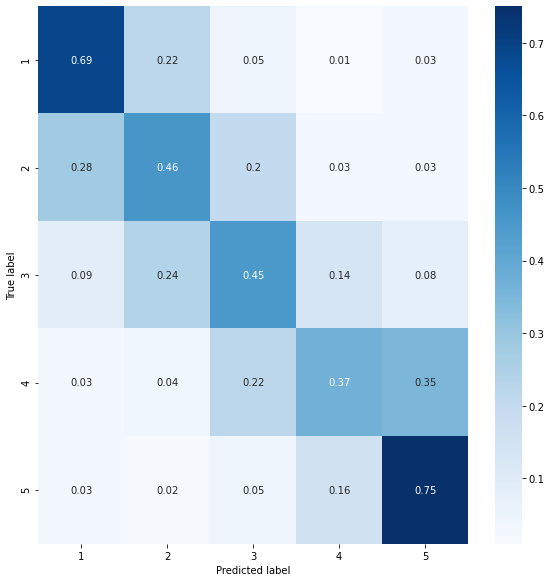

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

pred_Y = model.predict_classes(val_X)
val_Y = [np.argmax(x) for x in val_Y]
confusion_matrix = tf.math.confusion_matrix(labels=val_Y, predictions=pred_Y).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
confusion_matrix = pd.DataFrame(confusion_matrix, index=[1, 2, 3, 4, 5], columns=[1, 2, 3, 4, 5])

figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As we can see, the confusion matrix does a lot better job than accuracy at measuring the success of the model. Rather
than just knowing that the model hits just 54.14% accuracy, we can see that the model does quite a good job at staying
close to the true value. The model predicts 90.2% or ratings between 1 of the true value. I think this is pretty
successful especially considering that a review is somewhat subjective.

I plan on applying this model to the postrace analysis data (with some slight adjustments).